In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Read Data
df = pd.read_csv('rawdata.csv')

# Clean Data
df_cleaned = df.drop_duplicates()
df_cleaned = df.dropna()
df_cleaned = df_cleaned.filter(['pl_name', 'hostname', 'default_flag', 'sy_snum', 'sy_pnum',
       'pl_controv_flag', 'pl_orbper', 'pl_orbsmax', 'pl_rade', 'pl_radj', 'pl_bmasse', 'pl_bmassj', 'pl_orbeccen', 'pl_insol', 'pl_eqt', 'st_teff', 'st_rad',
       'st_mass', 'st_met', 'st_metratio', 'st_logg', 'sy_dist'])

In [3]:
# Calculate Density
EARTH_MASS_KG = 5.972e24
EARTH_RADIUS_M = 6.371e6  # meters


df_cleaned["density_kg_m3"] = (
    df_cleaned["pl_bmasse"] * EARTH_MASS_KG
    / ((4/3) * np.pi * (df_cleaned["pl_rade"] * EARTH_RADIUS_M) ** 3)
)


# If you want g/cm³:
df_cleaned["density_g_cm3"] = df_cleaned["density_kg_m3"] / 1000

# Calculate Inner Boundary
df_cleaned["planet_type"] = np.where(
    df_cleaned["density_g_cm3"] >= 3,
    "Terrestrial",
    "Gaseous"
)


In [4]:
import plotly.express as px


fig = px.histogram(
    df_cleaned,
    x="density_g_cm3",       # numeric column on x-axis
    color="planet_type",     # hue by category
    nbins=30,
    barmode="overlay",
    title="Interactive Planet Density Distribution"
)
fig.update_layout(
    xaxis_title="Density (g/cm³)",
    yaxis_title="Number of Planets",
    bargap=0.05
)
fig.show(renderer="browser")

<Axes: xlabel='density_g_cm3', ylabel='Count'>

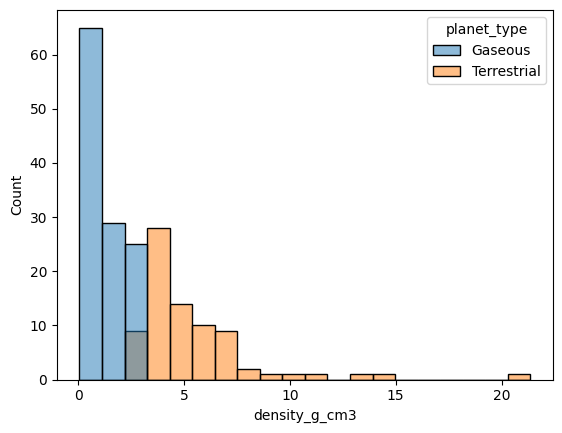

In [5]:
df_cleaned.head()

sns.histplot(data=df_cleaned,x="density_g_cm3",hue="planet_type")

In [10]:
import plotly.graph_objects as go


# 1) Choose stats (numeric columns you want to compare)
stats_cols = ["pl_rade", "pl_bmasse", "pl_insol", "pl_eqt", "st_teff", "pl_orbeccen"]


# 2) Make a normalized copy (0–100 scale). Invert any columns where "lower is better".
def minmax_0_100(s):
    s = s.astype(float)
    mn, mx = s.min(), s.max()
    return (100 * (s - mn) / (mx - mn)) if mx > mn else pd.Series(50, index=s.index)


df_norm = df_cleaned.copy()
for c in stats_cols:
    df_norm[c] = minmax_0_100(df_cleaned[c])


# Example: invert eccentricity so circular (low e) appears "better" (higher on the chart)


In [7]:
def scale_value_to_0_100(df_col: pd.Series, value: float) -> float:
    mn, mx = float(df_col.min()), float(df_col.max())
    if mx > mn:
        return 100 * (value - mn) / (mx - mn)
    return 50.0


# --- normalize your dataframe (0..100) ---
df_norm = df_cleaned.copy()
for c in stats_cols:
    df_norm[c] = minmax_0_100(df_cleaned[c])


# --- columns where "lower is better" -> invert after scaling ---
invert_cols = {"pl_orbeccen"}  # ecc: more circular (lower) should score higher
for c in stats_cols:
    if c in invert_cols:
        df_norm[c] = 100 - df_norm[c]



# --- Earth "true" values in catalog units ---
earth_true = {
    "pl_rade"    : 1.0,       # Earth radii
    "pl_bmasse"  : 1.0,       # Earth masses
    "pl_insol"   : 1.0,       # Earth = 1
    "pl_eqt"     : 255.0,     # K (equilibrium temp, not 288 K surface)
    "st_teff"    : 5772.0,    # K (Sun)
    "pl_orbeccen": 0.0167     # Earth's orbital eccentricity
}


# --- scale Earth using the SAME min/max as your dataset, then invert where needed ---
earth_scaled = {}
for c in stats_cols:
    val0_100 = scale_value_to_0_100(df_cleaned[c], earth_true[c])
    if c in invert_cols:
        val0_100 = 100 - val0_100
    earth_scaled[c] = val0_100
earth_row = pd.Series(earth_scaled)


In [9]:
tats_cols = ["pl_rade", "pl_bmasse", "pl_insol", "pl_eqt", "st_teff", "pl_orbeccen"]


# --- helpers: min-max to 0..100 and single-value scaler using the df range ---
def minmax_0_100(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    mn, mx = s.min(), s.max()
    return (100 * (s - mn) / (mx - mn)) if mx > mn else pd.Series(50, index=s.index)


def scale_value_to_0_100(df_col: pd.Series, value: float) -> float:
    mn, mx = float(df_col.min()), float(df_col.max())
    if mx > mn:
        return 100 * (value - mn) / (mx - mn)
    return 50.0


# --- normalize your dataframe (0..100) ---
df_norm = df_cleaned.copy()
for c in stats_cols:
    df_norm[c] = minmax_0_100(df_cleaned[c])


# --- columns where "lower is better" -> invert after scaling ---
invert_cols = {"pl_orbeccen"}  # ecc: more circular (lower) should score higher
for c in stats_cols:
    if c in invert_cols:
        df_norm[c] = 100 - df_norm[c]



# --- Earth "true" values in catalog units ---
earth_true = {
    "pl_rade"    : 1.0,       # Earth radii
    "pl_bmasse"  : 1.0,       # Earth masses
    "pl_insol"   : 1.0,       # Earth = 1
    "pl_eqt"     : 255.0,     # K (equilibrium temp, not 288 K surface)
    "st_teff"    : 5772.0,    # K (Sun)
    "pl_orbeccen": 0.0167     # Earth's orbital eccentricity
}


# --- scale Earth using the SAME min/max as your dataset, then invert where needed ---
earth_scaled = {}
for c in stats_cols:
    val0_100 = scale_value_to_0_100(df_cleaned[c], earth_true[c])
    if c in invert_cols:
        val0_100 = 100 - val0_100
    earth_scaled[c] = val0_100
earth_row = pd.Series(earth_scaled)


